# Cryptographic Analysis: "Close to Random" Boolean Functions

Boolean functions used in cryptography must resist statistical attacks. The central question:

> **How "random-looking" is a Boolean function?**

This notebook explores the cryptographic properties that quantify randomness:

1. **Nonlinearity** — distance to the nearest affine function
2. **Walsh spectrum** — the frequency-domain fingerprint that reveals structure
3. **Bent functions** — maximum nonlinearity, the "most random" functions
4. **Strict Avalanche Criterion (SAC)** — flipping one input bit changes the output with probability 1/2
5. **Correlation immunity** — output is statistically independent of small subsets of inputs

### Why This Matters

- **Stream ciphers**: Combining functions must have high nonlinearity to resist linear cryptanalysis
- **Block ciphers**: S-boxes must satisfy SAC and have low differential uniformity
- **Hash functions**: Component functions need high algebraic degree and correlation immunity

In [1]:
# Setup
!pip install --upgrade boofun -q

import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis.cryptographic import (
    walsh_transform, walsh_spectrum, nonlinearity, is_bent,
    is_balanced, algebraic_degree, correlation_immunity,
    strict_avalanche_criterion, CryptographicAnalyzer,
)

np.random.seed(42)
print(f"boofun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


boofun version: 1.1.1


## 1. The Walsh Spectrum: A Function's Fingerprint

The **Walsh transform** $W_f(a) = \sum_{x} (-1)^{f(x) \oplus \langle a, x \rangle}$ measures the correlation between $f$ and each linear function. The **Walsh spectrum** is the histogram of these values.

- **Flat spectrum** (all $|W_f(a)|$ equal) $\Rightarrow$ bent function (maximum nonlinearity)
- **Spiky spectrum** (large peaks) $\Rightarrow$ correlated with some linear function (weak)

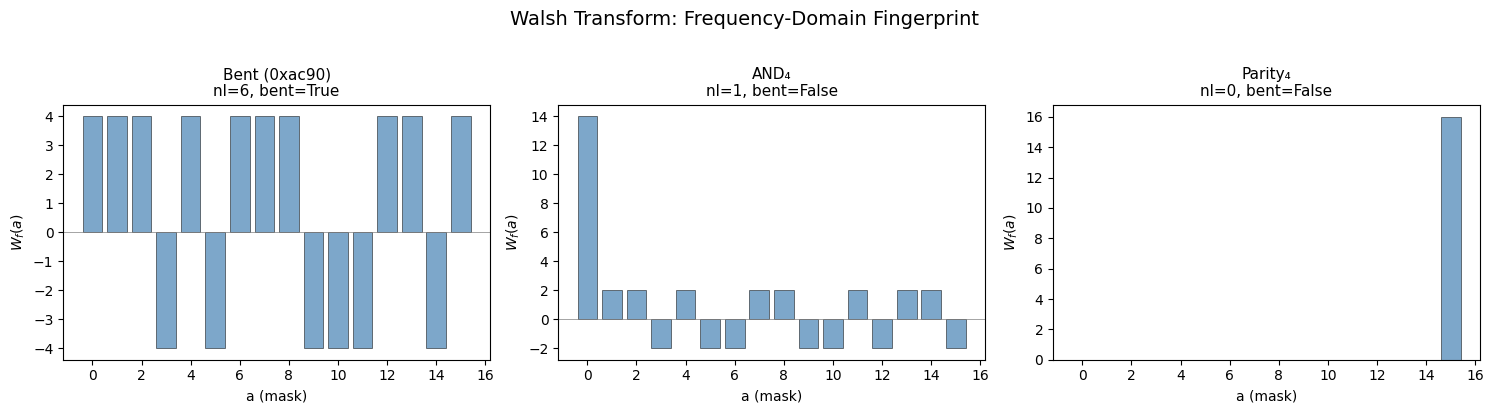

Bent: all |W_f(a)| = 2^(n/2) = 4 → flat spectrum → maximum nonlinearity
AND: uneven spectrum → some linear correlations → lower nonlinearity
Parity: W_f has a single peak at a=1111 → perfectly linear → nonlinearity = 0


In [2]:
# Walsh spectrum comparison: bent vs structured vs random
bent_4 = bf.from_hex("ac90", n=4)    # 4-variable bent function
and_4 = bf.AND(4)                     # Structured function
xor_4 = bf.parity(4)                  # Maximally linear

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, f) in zip(axes, [("Bent (0xac90)", bent_4), ("AND\u2084", and_4), ("Parity\u2084", xor_4)]):
    wt = walsh_transform(f)
    ax.bar(range(len(wt)), wt, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_xlabel('a (mask)', fontsize=10)
    ax.set_ylabel('$W_f(a)$', fontsize=10)
    ax.set_title(f'{name}\nnl={nonlinearity(f)}, bent={is_bent(f)}', fontsize=11)
    ax.axhline(y=0, color='gray', linewidth=0.5)

plt.suptitle('Walsh Transform: Frequency-Domain Fingerprint', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Bent: all |W_f(a)| = 2^(n/2) = 4 \u2192 flat spectrum \u2192 maximum nonlinearity")
print("AND: uneven spectrum \u2192 some linear correlations \u2192 lower nonlinearity")
print("Parity: W_f has a single peak at a=1111 \u2192 perfectly linear \u2192 nonlinearity = 0")

## 2. Nonlinearity Landscape

**Nonlinearity** $\text{nl}(f) = 2^{n-1} - \frac{1}{2}\max_a|W_f(a)|$ is the Hamming distance from $f$ to the nearest affine function. The maximum achievable nonlinearity is $2^{n-1} - 2^{n/2 - 1}$ (achieved by bent functions, which exist only for even $n$).

In [3]:
# Nonlinearity comparison across function families
functions = [
    ("Bent (0xac90)", bf.from_hex("ac90", n=4)),
    ("AND\u2084", bf.AND(4)),
    ("OR\u2084", bf.OR(4)),
    ("Majority\u2085", bf.majority(5)),
    ("Tribes(2,3)", bf.tribes(2, 3)),
    ("Parity\u2084", bf.parity(4)),
    ("Dictator\u2084", bf.dictator(4, 0)),
]

print(f"{'Function':<18} {'n':>3} {'Nonlinearity':>13} {'Max possible':>13} {'Bent?':>6} {'Balanced?':>10}")
print("-" * 67)
for name, f in functions:
    n = f.n_vars
    nl = nonlinearity(f)
    max_nl = 2**(n-1) - 2**(n//2 - 1) if n % 2 == 0 else "N/A"
    print(f"{name:<18} {n:>3} {nl:>13} {str(max_nl):>13} {str(is_bent(f)):>6} {str(is_balanced(f)):>10}")

print()
print("\u2192 Bent function achieves maximum nonlinearity (most resistant to linear attacks)")
print("\u2192 Parity and Dictator have zero nonlinearity (they ARE affine/near-affine)")
print("\u2192 Majority has moderate nonlinearity despite being a natural, structured function")

Function             n  Nonlinearity  Max possible  Bent?  Balanced?
-------------------------------------------------------------------
Bent (0xac90)        4             6             6   True      False
AND₄                 4             1             6  False      False
OR₄                  4             1             6  False      False
Majority₅            5            10           N/A  False       True
Tribes(2,3)          3             1           N/A  False      False
Parity₄              4             0             6  False       True
Dictator₄            4             0             6  False       True

→ Bent function achieves maximum nonlinearity (most resistant to linear attacks)
→ Parity and Dictator have zero nonlinearity (they ARE affine/near-affine)
→ Majority has moderate nonlinearity despite being a natural, structured function


## 3. Strict Avalanche Criterion (SAC)

A function satisfies **SAC** if flipping any single input bit changes the output with probability exactly $1/2$. This ensures that small input changes produce unpredictable output changes — a desirable property for cipher components.

SAC is equivalent to saying that all derivatives $D_i f(x) = f(x) \oplus f(x \oplus e_i)$ are balanced.

In [4]:
# SAC analysis
print("Strict Avalanche Criterion:")
print(f"{'Function':<18} {'SAC?':>6} {'Correlation Immunity':>22} {'Algebraic Degree':>18}")
print("-" * 68)

for name, f in functions:
    sac = strict_avalanche_criterion(f)
    ci = correlation_immunity(f)
    deg = algebraic_degree(f)
    print(f"{name:<18} {str(sac):>6} {ci:>22} {deg:>18}")

print()
print("\u2192 Bent functions satisfy SAC (maximum avalanche effect)")
print("\u2192 AND/OR fail SAC badly (flipping the right bit has deterministic effect)")
print("\u2192 Higher correlation immunity = harder to break with correlation attacks")

Strict Avalanche Criterion:
Function             SAC?   Correlation Immunity   Algebraic Degree
--------------------------------------------------------------------
Bent (0xac90)        True                      0                  2
AND₄                False                      0                  4
OR₄                 False                      0                  4
Majority₅           False                      0                  4
Tribes(2,3)         False                      0                  3
Parity₄             False                      3                  1
Dictator₄           False                      0                  1

→ Bent functions satisfy SAC (maximum avalanche effect)
→ AND/OR fail SAC badly (flipping the right bit has deterministic effect)
→ Higher correlation immunity = harder to break with correlation attacks


## 4. Full Cryptographic Profile

The `CryptographicAnalyzer` class provides a comprehensive view of all cryptographic properties at once.

In [5]:
# Full cryptographic profile of a bent function
bent = bf.from_hex("ac90", n=4)
ca = CryptographicAnalyzer(bent)
print("Cryptographic profile of bent function 0xac90:")
print(ca.summary())
print()

# Compare with AND
and_ca = CryptographicAnalyzer(bf.AND(4))
print("Cryptographic profile of AND\u2084:")
print(and_ca.summary())

Cryptographic profile of bent function 0xac90:
CryptographicAnalyzer (n=4)
  Nonlinearity: 6 / 6 (max possible)
  Balanced: False
  Bent: True
  Algebraic degree: 2
  Correlation immunity: 0
  Resiliency: -1
  Satisfies SAC: True

  Walsh spectrum: {-4: 6, 4: 10}

Cryptographic profile of AND₄:
CryptographicAnalyzer (n=4)
  Nonlinearity: 1 / 6 (max possible)
  Balanced: False
  Bent: False
  Algebraic degree: 4
  Correlation immunity: 0
  Resiliency: -1
  Satisfies SAC: False

  Walsh spectrum: {-2: 7, 2: 8, 14: 1}


## 5. Visualizing Cryptographic Strength

A radar chart comparing key cryptographic properties across functions gives an at-a-glance view of their suitability for cryptographic applications.

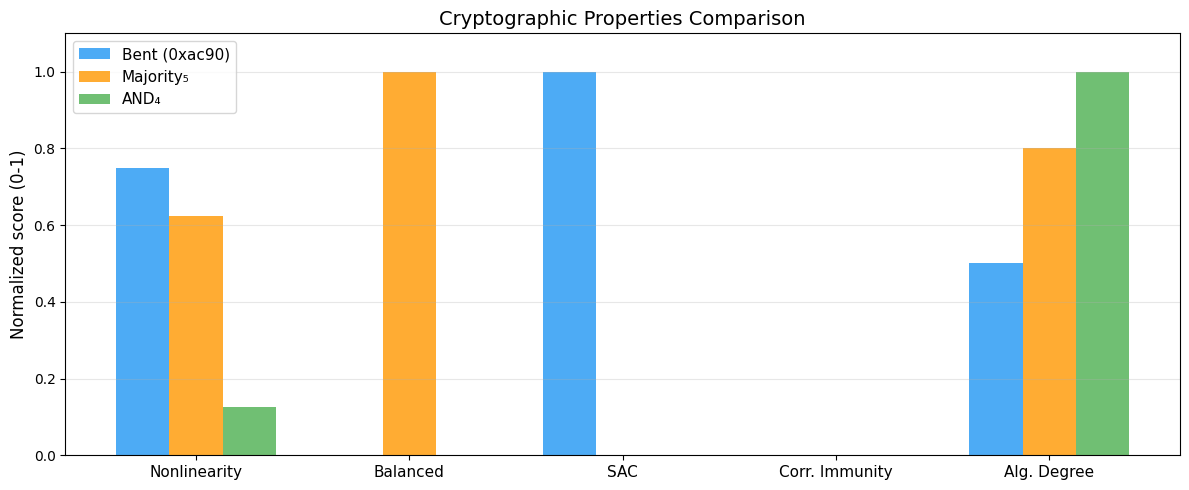

The bent function scores high on all metrics — the gold standard for crypto.
AND has high algebraic degree but fails at nonlinearity, balance, and SAC.


In [6]:
# Radar chart: cryptographic properties comparison
from matplotlib.patches import FancyBboxPatch

funcs_to_compare = [
    ("Bent (0xac90)", bf.from_hex("ac90", n=4)),
    ("Majority\u2085", bf.majority(5)),
    ("AND\u2084", bf.AND(4)),
]

# Collect normalized metrics
metrics = ["Nonlinearity", "Balanced", "SAC", "Corr. Immunity", "Alg. Degree"]
data = []
for name, f in funcs_to_compare:
    n = f.n_vars
    max_nl = 2**(n-1)
    nl_norm = nonlinearity(f) / max_nl if max_nl > 0 else 0
    bal = 1.0 if is_balanced(f) else 0.0
    sac = 1.0 if strict_avalanche_criterion(f) else 0.0
    ci_norm = correlation_immunity(f) / n if n > 0 else 0
    deg_norm = algebraic_degree(f) / n if n > 0 else 0
    data.append([nl_norm, bal, sac, ci_norm, deg_norm])

# Bar chart comparison
x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#2196F3', '#FF9800', '#4CAF50']
for i, (name, _) in enumerate(funcs_to_compare):
    ax.bar(x + i * width, data[i], width, label=name, color=colors[i], alpha=0.8)

ax.set_xticks(x + width)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylabel('Normalized score (0-1)', fontsize=12)
ax.set_title('Cryptographic Properties Comparison', fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("The bent function scores high on all metrics \u2014 the gold standard for crypto.")
print("AND has high algebraic degree but fails at nonlinearity, balance, and SAC.")

## Summary

### What Makes a Function "Close to Random"?

| Property | Meaning | Ideal |
|----------|---------|-------|
| **Nonlinearity** | Distance from affine functions | $2^{n-1} - 2^{n/2-1}$ (bent) |
| **Walsh spectrum** | Correlation with linear functions | Flat (all $|W_f(a)|$ equal) |
| **Balanced** | Equal 0s and 1s in truth table | Yes |
| **SAC** | Flipping one bit changes output w.p. 1/2 | Yes |
| **Correlation immunity** | Output independent of $t$ inputs | High $t$ |
| **Algebraic degree** | Degree of ANF representation | High |

**Bent functions** are the theoretical ideal: they achieve maximum nonlinearity and satisfy SAC. However, they are never balanced for $n > 2$, so practical ciphers use near-bent constructions.

### boofun API

```python
from boofun.analysis.cryptographic import (
    CryptographicAnalyzer, walsh_transform, walsh_spectrum,
    nonlinearity, is_bent, is_balanced,
    algebraic_degree, correlation_immunity,
    strict_avalanche_criterion,
)

ca = CryptographicAnalyzer(f)
ca.summary()  # Full cryptographic profile
```

### References

- Rothaus (1976): On bent functions
- Webster-Tavares (1986): Strict Avalanche Criterion
- Siegenthaler (1984): Correlation immunity and algebraic degree tradeoff

---

*This notebook demonstrates the `boofun.analysis.cryptographic` module.*